# 1) Préparation de la dataset :


## 1.1- Importing Libraries And dataset

In [48]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,  TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
%matplotlib inline

In [49]:
#Récupération du dataset


df = pd.read_csv("why-questions+answers.txt", delimiter ="\t", header=0, index_col=[0],names=['quest','topic','anwer1','answer2','document'])
df = df[pd.notnull(df['document'])]
df.reset_index(drop = False, inplace = True)
df.head(5)

#df.shape



,quest,topic,anwer1,answer2,document
0,Why are abortion rights groups concerned on th...,Abortion rights are concerned on the outcome o...,They are worried that thousands of women may d...,The Supreme Court could overturn the 1973 ruli...,6
1,Why are abortion rights groups opposing the Bu...,Abortion rights groups are opposing the Bush a...,Because they think thousands of women would di...,because they don't want the 1973 ruling to be ...,6
2,Why are cereal farmers happy about population ...,The cereal farmers are happy about population ...,They are happy because it gives them a large c...,Because there will be more mouths to feed - th...,9
3,Why are classes likely to be even bigger in th...,Classes are likely to be even bigger in the au...,Because the school population is set to rise b...,"The school population will rise by 74,000 and ...",1
4,Why are classes likely to be even bigger in th...,Classes are likely to be even bigger in the au...,Because of the indications about school admiss...,"There will be 74,000 new students, which will ...",1


## 1.2- épurer le dataset :


In [50]:
## On élimine les colonnes dont on a pas besoin

col = ['quest', 'document']
df = df[col]
df.columns = ['quest', 'document']
df['category_id'] = df['document'].factorize()[0]
df.head(10)
#print(df['answer'].apply(lambda x: len(x.split(' '))).sum())    [ just to see how much words there is to work on]

,quest,document,category_id
0,Why are abortion rights groups concerned on th...,6,0
1,Why are abortion rights groups opposing the Bu...,6,0
2,Why are cereal farmers happy about population ...,9,1
3,Why are classes likely to be even bigger in th...,1,2
4,Why are classes likely to be even bigger in th...,1,2
5,Why are compilers of Spain's answer to the Oxf...,4,3
6,Why are compilers of the Spanish equivalent to...,4,3
7,Why are conservatives in the US reluctant to s...,8,4
8,Why are conservatives raising the issue of the...,8,4
9,Why are conservatives reraising the issue of t...,8,4


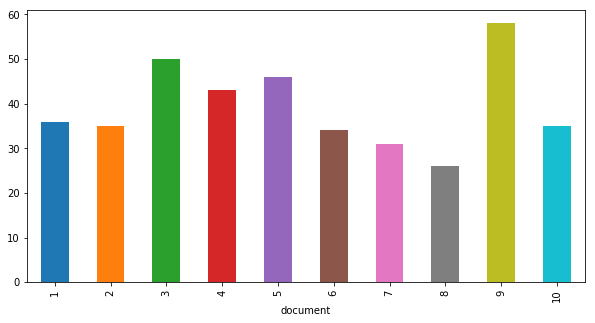

In [51]:
# là on essais de voir si les catégories sont équilibrée ... pas parfaitement dans notre cas


fig = plt.figure(figsize=(10,5))
df.groupby('document').quest.count().plot.bar(ylim=0)
plt.show()

In [52]:
# print_plot est une fonction qui renvoit directement la donnée correspendante à l'index entré :

def print_plot(index):
    example = df[df.index == index][['quest', 'document']].values[0]
    if len(example) > 0:
        print(example[0])
        print('document:', example[1])
        

print_plot(1)

Why are abortion rights groups opposing the Bush administration and the state of Missouri?
document: 6


## Pre-traitement

## 1.3- determiner les regex et épurer les données :

In [53]:
# on determine les regex à remplacer ou supprimer du texte:

replace = re.compile('[/(){}\[\]\|@,;]')
symbols = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
num = re.compile('^[-+]?[0-9]+$')

In [54]:
#cleaning data funtion :

def clean_text(text):
    
    text = text.lower() # lowercase text
    text = replace.sub(' ', text) # on remplace des caractères par un espace
    text = symbols.sub('', text) # on supprime des symboles du texte
    text = num.sub('',text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    #suppression des stop words
    
    return text

In [55]:
#juste un teste

print_plot(1)
df['quest'] = df['quest'].apply(clean_text)
print("\n\n")
print_plot(1)

Why are abortion rights groups opposing the Bush administration and the state of Missouri?
document: 6



abortion rights groups opposing bush administration state missouri
document: 6


## 1.4- Stemming et Lemmetization : 

In [56]:
# Stemming and lemmetization
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

questions = df['quest'].tolist()

sno = nltk.stem.SnowballStemmer('english')
lemma = nltk.wordnet.WordNetLemmatizer()


def sentStem(text):
    stem_sent = []
    
    words = word_tokenize(text)
    
    for w in words:
        w = lemma.lemmatize(w)
        stem_sent.append(sno.stem(w))
        stem_sent.append(" ")
        
    return "".join(stem_sent)  


# TEST :
print("BEFOR : ")
print(questions[0])
print ("\n******\n")
print("AFTER : ")
print(sentStem(questions[0]))



BEFOR : 
abortion rights groups concerned outcome supreme courts decision

******

AFTER : 
abort right group concern outcom suprem court decis 


##  Dictionnaire de correspendance (needed pour plutard)  :


In [57]:
# dictionnaire du in au titre du document : 

category_id_df = df[['document', 'category_id']].drop_duplicates().sort_values('document')

id_to_doc = dict()
id_to_doc = {  1 : 'Guardian_BigClasses.txt',
             2: 'Guardian_Elections.txt',
             3 : 'Guardian_McDonalds.txt',
              4 : 'Guardian_SpanishDict.txt',
               5 :  'Guardian_Windows3.txt',
               6 : 'Reuters_Abortion.txt',
               7:  'Reuters_Azerbaijan.txt',
               8:  'Reuters_Canal.txt',
               9:  'Reuters_Population.txt',
               10: 'Reuters_SecretPolice.txt'}


# dictionnaire du titre au id : 
doc_to_id = dict()
doc_to_id = id_to_doc = { 'Guardian_BigClasses.txt':  1,
               'Guardian_Elections.txt':  2,
              'Guardian_McDonalds.txt': 3,
             'Guardian_SpanishDict.txt':  4, 
               'Guardian_Windows3.txt':  5,
             'Reuters_Abortion.txt':  6,
             'Reuters_Azerbaijan.txt':  7,
             'Reuters_Canal.txt':  8,
            'Reuters_Population.txt':  9,
             'Reuters_SecretPolice.txt':  10}



# 1.4 feature extraction (Représentation par TF-IDF)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.quest).toarray()

labels = df.document
features.shape
#print(features[8])

(394, 104)

# 2) Application des algorithmes : 


## 2.1- Spliting dataset for training the models :

In [59]:
#NEDED !! 
cat=[ 'Document 1 : Guardian_BigClasses',
               'Document 2 : Guardian Elections',
              'Document 3 : Guardian McDonalds',
             'Document 4 : Guardian SpanishDict', 
               'Document 5 : Guardian Windows3',
             'Document 6 : Reuters Abortion',
             'Document 7 : Reuters Azerbaijan',
             'Document 8 : Reuters Canal ',
            'Document 9 : Reuters Population',
             'Document 10 : Reuters SecretPolice']


In [60]:
from sklearn.model_selection import train_test_split
x = df.quest
y = df.document

x_train, x_test, y_train, y_test = train_test_split(df['quest'], df['document'], random_state = 0)



## Algo 1- Naive Bayes : 

In [61]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

naive_bayes = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clasf', MultinomialNB()),
              ])

naive_bayes.fit(x_train, y_train)


from sklearn.metrics import classification_report
y_pred = naive_bayes.predict(x_test)

print('précision %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred,target_names=cat))

précision 0.9090909090909091


## Algo 2- SGD :

In [62]:

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(x_train, y_train)


y_pred = sgd.predict(x_test)

print('précision %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=cat))

précision 0.9595959595959596
                                    precision    recall  f1-score   support

  Document 1 : Guardian_BigClasses       0.82      1.00      0.90         9
   Document 2 : Guardian Elections       1.00      1.00      1.00         6
   Document 3 : Guardian McDonalds       0.94      1.00      0.97        17
 Document 4 : Guardian SpanishDict       1.00      1.00      1.00        14
    Document 5 : Guardian Windows3       0.92      0.92      0.92        13
     Document 6 : Reuters Abortion       1.00      0.75      0.86         8
   Document 7 : Reuters Azerbaijan       1.00      1.00      1.00         8
       Document 8 : Reuters Canal        1.00      1.00      1.00         6
   Document 9 : Reuters Population       1.00      0.92      0.96        12
Document 10 : Reuters SecretPolice       1.00      1.00      1.00         6

                         micro avg       0.96      0.96      0.96        99
                         macro avg       0.97      0.96  

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


## Algo 3- Logistic regression

In [63]:

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(x_train, y_train)


y_pred = logreg.predict(x_test)

print('précision %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=cat))

précision 0.9494949494949495
                                    precision    recall  f1-score   support

  Document 1 : Guardian_BigClasses       0.82      1.00      0.90         9
   Document 2 : Guardian Elections       1.00      1.00      1.00         6
   Document 3 : Guardian McDonalds       1.00      0.94      0.97        17
 Document 4 : Guardian SpanishDict       1.00      1.00      1.00        14
    Document 5 : Guardian Windows3       0.86      0.92      0.89        13
     Document 6 : Reuters Abortion       1.00      0.75      0.86         8
   Document 7 : Reuters Azerbaijan       1.00      1.00      1.00         8
       Document 8 : Reuters Canal        1.00      1.00      1.00         6
   Document 9 : Reuters Population       0.92      0.92      0.92        12
Document 10 : Reuters SecretPolice       1.00      1.00      1.00         6

                         micro avg       0.95      0.95      0.95        99
                         macro avg       0.96      0.95  

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Comparaison de 4 algorithmes : 


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import seaborn as sns

    #****************************************
# on crée un lite des model que nous voulons comparer :

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=5),
    
]

CV = 5 #Pour refaire la prédiction 5 fois et donc avoir des résultats de précisions plus optimaux

cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

        


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be ch

              nom du model  itération  précision
0   RandomForestClassifier          0   0.530120
1   RandomForestClassifier          1   0.556962
2   RandomForestClassifier          2   0.569620
3   RandomForestClassifier          3   0.662338
4   RandomForestClassifier          4   0.526316
5                LinearSVC          0   0.807229
6                LinearSVC          1   0.734177
7                LinearSVC          2   0.848101
8                LinearSVC          3   0.896104
9                LinearSVC          4   0.855263
10           MultinomialNB          0   0.795181
11           MultinomialNB          1   0.734177
12           MultinomialNB          2   0.860759
13           MultinomialNB          3   0.883117
14           MultinomialNB          4   0.776316
15      LogisticRegression          0   0.783133
16      LogisticRegression          1   0.746835
17      LogisticRegression          2   0.873418
18      LogisticRegression          3   0.896104
19      LogisticRegr

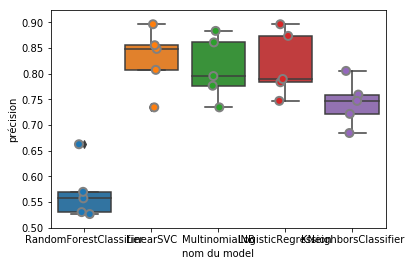

In [74]:
#on crée une datafram pour stocker les résultats des models :        
cv_df = pd.DataFrame(entries, columns=['nom du model', 'itération', 'précision']) 

print(cv_df)

sns.boxplot(x='nom du model', y='précision', data=cv_df)

sns.stripplot(x='nom du model', y='précision', data=cv_df, 
              size=8, jitter=True, edgecolor="grey", linewidth=2)
plt.show()


# évaluation du model (Linear SVC avec matrice de confusion):


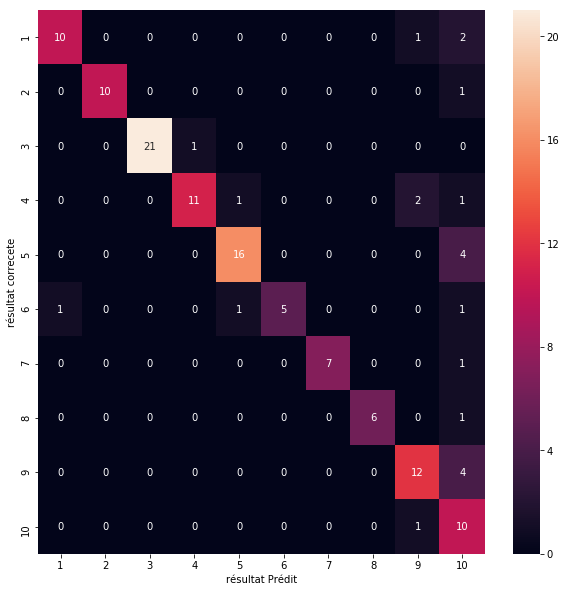

In [73]:
#linear SVC : 
from sklearn.metrics import confusion_matrix


model = LinearSVC()

x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#print(category_id_df)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.document.values, yticklabels=category_id_df.document.values)


# Affichage
plt.ylabel("résultat correcete")
plt.xlabel('résultat Prédit')
plt.show()

#  Interface Graphique 


In [3]:
from tkinter import *

In [4]:
#functions : 

def classify():
    txt_entre=texte.get() #on récup le texte
    

In [7]:
# On crée une fenêtre, racine de notre interface
fenetre = Tk()
fenetre.title("teste du model")
fenetre.configure(background="white")


# On crée un label (ligne de texte) souhaitant la bienvenue
# Note : le premier paramètre passé au constructeur de Label est notre interface racine
champ_label = Label(fenetre, text="Classification de text",bg="white",fg="black")
champ_label.pack()


#la bare de texte : 
texte= Entry(fenetre,width=90,bg="white")
texte.pack()

#Bouton classifier : 
bout_class= Button(fenetre,text="Classifier le texte",width=20,command=classify)
bout_class.pack()


# On démarre la boucle Tkinter qui s'interompt quand on ferme la fenêtre
fenetre.mainloop()